In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


In [5]:
IMG_SIZE = 224
DATA_DIR = "data"
IMG_DIR = os.path.join(DATA_DIR, "images")
ANN_DIR = os.path.join(DATA_DIR, "annotations")

CLASSES = ["with_mask", "without_mask", "mask_weared_incorrect"]


In [12]:
import xml.etree.ElementTree as ET

def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    labels = []
    for obj in root.findall("object"):
        labels.append(obj.find("name").text)

    return labels


In [16]:
images = []
labels = []

for img_name in os.listdir(IMG_DIR):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    xml_path = os.path.join(
        ANN_DIR,
        img_name.replace(".jpg", ".xml").replace(".png", ".xml")
    )

    if not os.path.exists(xml_path):
        continue

    img = cv2.imread(os.path.join(IMG_DIR, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    lbls = parse_xml(xml_path)

    images.append(img)
    labels.append(lbls[0])


In [15]:
print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("ANN_DIR exists:", os.path.exists(ANN_DIR))

print("Images count:", len(os.listdir(IMG_DIR)) if os.path.exists(IMG_DIR) else 0)
print("Annotations count:", len(os.listdir(ANN_DIR)) if os.path.exists(ANN_DIR) else 0)


IMG_DIR exists: True
ANN_DIR exists: True
Images count: 853
Annotations count: 853


In [17]:
label_counts = Counter(labels)
label_counts


Counter({'with_mask': 698, 'without_mask': 119, 'mask_weared_incorrect': 36})

In [18]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X = np.array(images)
y = np.array(y_encoded)

print("Encoded classes mapping:")
for i, cls in enumerate(le.classes_):
    print(i, "->", cls)


Encoded classes mapping:
0 -> mask_weared_incorrect
1 -> with_mask
2 -> without_mask


In [19]:
base_model = MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = False

features = base_model.predict(X, batch_size=32)

print("Feature shape:", features.shape)


27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 654ms/step
Feature shape: (853, 1280)


In [20]:
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(features, y)

print("Class distribution after SMOTE:")
Counter(y_smote)


c:\Users\sinha\anaconda3\envs\project\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Class distribution after SMOTE:


Counter({np.int64(2): 698, np.int64(1): 698, np.int64(0): 698})

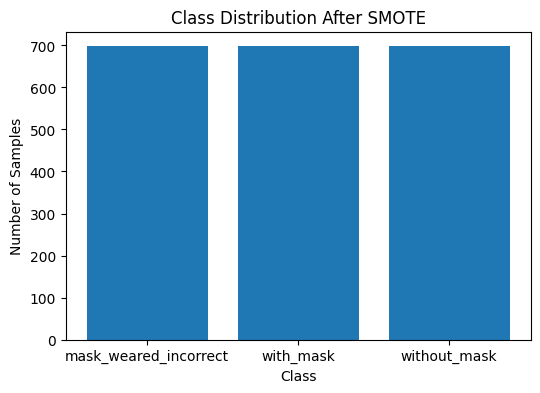

In [21]:
plt.figure(figsize=(6, 4))
plt.bar(
    le.inverse_transform(np.unique(y_smote)),
    Counter(y_smote).values()
)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smote,
    y_smote,
    test_size=0.2,
    random_state=42,
    stratify=y_smote
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Train samples: 1675
Test samples: 419


In [23]:
inputs = Input(shape=(X_train.shape[1],))

x = Dense(256, activation="relu")(inputs)
x = Dense(128, activation="relu")(x)

outputs = Dense(len(CLASSES), activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,219 (1.38 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6380 - loss: 0.7822 - val_accuracy: 0.9164 - val_loss: 0.2077
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9686 - loss: 0.1216 - val_accuracy: 0.9522 - val_loss: 0.1390
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0361 - val_accuracy: 0.9552 - val_loss: 0.1093
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0170 - val_accuracy: 0.9612 - val_loss: 0.1149
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9672 - val_loss: 0.0856
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9642 - val_loss: 0.1057
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9642 - val_loss: 0.1351
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9672 - val_loss:

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", round(test_loss, 4))
print("Test Accuracy:", round(test_accuracy, 4))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.1364 
Test Loss: 0.1296
Test Accuracy: 0.969


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


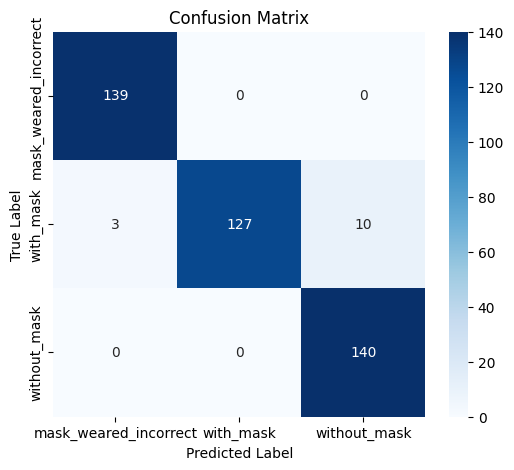

Classification Report:

                       precision    recall  f1-score   support

mask_weared_incorrect       0.98      1.00      0.99       139
            with_mask       1.00      0.91      0.95       140
         without_mask       0.93      1.00      0.97       140

             accuracy                           0.97       419
            macro avg       0.97      0.97      0.97       419
         weighted avg       0.97      0.97      0.97       419



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
